# Optimizing Airbnb Rental Strategies in New York City

In [4]:
#importing the libraries for data cleaning/data preprocessing and Exploratory data analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from wordcloud import WordCloud
sns.set(style="whitegrid") 

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv('AB_NYC_2019.csv')

In [6]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [7]:
# Display the first few rows of the DataFrame to understand its structure and contents
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Data cleaning/Preprocessing

In [8]:
# Convert 'last_review' to datetime format from string format.
df['last_review'] = pd.to_datetime(df['last_review'])

In [9]:
#  Filling missing 'name' and 'host_name' with "Unknown"
df['name'].fillna('Unknown',inplace=True)
df['host_name'].fillna('Unknown',inplace=True)

In [10]:
#checks for the null values in the rows and columns.
np.where(pd.isnull(df))

(array([    2,     2,    19, ..., 48893, 48894, 48894], dtype=int64),
 array([12, 13, 12, ..., 13, 12, 13], dtype=int64))

In [11]:
#checks and returns the complete list of null values in the dataset.
#[df.iloc[i,j] for i,j in zip(*np.where(pd.isnull(df)))]

In [12]:
#checks if the particular location has null values(Random verification)
df.iloc[2,13]

nan

In [13]:
#data types of all the columns are verified for cleaner data processing.
df.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

In [14]:
#lists us with all the unique objects in the features.
for column in df.select_dtypes(include=['object']).columns:
    print(f"{column}: {df[column].nunique()} unique values")

name: 47906 unique values
host_name: 11453 unique values
neighbourhood_group: 5 unique values
neighbourhood: 221 unique values
room_type: 3 unique values


In [15]:
# Remove listings with unrealistic minimum nights (more than 365 days)
df = df[df['minimum_nights'] <= 365]


In [16]:
#  Remove outliers for 'price' (using IQR)
Q1_price = df['price'].quantile(0.25)
Q3_price = df['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price
df = df[(df['price'] >= lower_bound_price) & (df['price'] <= upper_bound_price)]

In [17]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.591000e+04,4.591000e+04,45910.000000,45910.000000,45910.000000,45910.000000,45910.000000,36905.000000,45910.000000,45910.000000
mean,1.889992e+07,6.633356e+07,40.728488,-73.950731,119.971052,6.757874,23.947833,1.378366,6.641189,109.328817
std,1.091899e+07,7.756090e+07,0.055333,0.046476,68.152280,16.001383,45.320305,1.692086,31.012404,130.248370
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.439158e+06,7.727013e+06,40.689230,-73.981928,65.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.952689e+07,3.029856e+07,40.721770,-73.954370,100.000000,2.000000,5.000000,0.710000,1.000000,39.000000
75%,2.891280e+07,1.055106e+08,40.763390,-73.934303,159.000000,5.000000,24.000000,2.020000,2.000000,216.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,334.000000,365.000000,629.000000,58.500000,327.000000,365.000000


In [18]:
#Shows us the number of rows and number of columns.
count_row = df.shape[0]  # Gives number of rows
count_col = df.shape[1]  # Gives number of columns

In [19]:
#this gives the number of rows.
count_row 

45910

In [20]:
#this gives the number of columns.
count_col

16

In [21]:
# Check for missing values
df.isnull().sum()

id                                   0
name                                 0
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       9005
reviews_per_month                 9005
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [22]:
#Fill missing 'reviews_per_month' with 0 (assuming no reviews means 0 per month)
df['reviews_per_month'].fillna(0)

0        0.21
1        0.38
2        0.00
3        4.64
4        0.10
         ... 
48890    0.00
48891    0.00
48892    0.00
48893    0.00
48894    0.00
Name: reviews_per_month, Length: 45910, dtype: float64

In [23]:
#Remove listings with a price of $0, as these are not realistic
df = df[df['price'] > 0]

In [24]:
df.shape[0] 

45899

In [25]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.589900e+04,4.589900e+04,45899.000000,45899.000000,45899.000000,45899.000000,45899.000000,36895.000000,45899.000000,45899.000000
mean,1.889952e+07,6.633540e+07,40.728491,-73.950737,119.999804,6.757729,23.945358,1.378269,6.641757,109.326042
std,1.092027e+07,7.756683e+07,0.055335,0.046478,68.135132,16.002435,45.321310,1.692036,31.016084,130.253339
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.436180e+06,7.720804e+06,40.689230,-73.981940,65.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.952538e+07,3.028459e+07,40.721780,-73.954370,100.000000,2.000000,5.000000,0.720000,1.000000,39.000000
75%,2.891372e+07,1.055431e+08,40.763405,-73.934325,159.000000,5.000000,24.000000,2.020000,2.000000,216.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,334.000000,365.000000,629.000000,58.500000,327.000000,365.000000


In [26]:
#  Remove rows where 'last_review' is NaT after conversion (no review date)
df = df.dropna(subset=['last_review'])

In [27]:
#Converted 'id' and 'host_id' to strings to ensure consistency in data types, as these identifiers do not require numerical operations.
df['id'] = df['id'].astype(str)
df['host_id'] = df['host_id'].astype(str)

In [28]:
df.dtypes

id                                        object
name                                      object
host_id                                   object
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

In [29]:
# Before resetting the index
print("Before reset:", df.columns)

Before reset: Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In [30]:
# Reset the index
df.reset_index(drop=True, inplace=True)

In [31]:
# After resetting the index
print("After reset:", df.columns)

After reset: Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In [32]:
# Normalize 'latitude' and 'longitude' - using Min-Max scaling
scaler=MinMaxScaler()
df[['latitude', 'longitude']] = scaler.fit_transform(df[['latitude', 'longitude']])

In [33]:
# Feature Engineering - Price per Night per Minimum Nights
df['price_per_night_per_min_night'] = df['price'] / df['minimum_nights']

In [34]:
df.head

<bound method NDFrame.head of              id                                              name    host_id  \
0          2539                Clean & quiet apt home by the park       2787   
1          2595                             Skylit Midtown Castle       2845   
2          3831                   Cozy Entire Floor of Brownstone       4869   
3          5022  Entire Apt: Spacious Studio/Loft by central park       7192   
4          5099         Large Cozy 1 BR Apartment In Midtown East       7322   
...         ...                                               ...        ...   
36890  36425863        Lovely Privet Bedroom with Privet Restroom   83554966   
36891  36427429                          No.2 with queen size bed  257683179   
36892  36438336                                   Seas The Moment  211644523   
36893  36442252                     1B-1B apartment near by Metro  273841667   
36894  36455809           Cozy Private Room in Bushwick, Brooklyn   74162901   

         

In [35]:
# Extract Year and Month from 'last_review'
df['review_year'] = df['last_review'].dt.year
df['review_month'] = df['last_review'].dt.month

In [36]:
# Standardize 'number_of_reviews'
scaler_standard = StandardScaler()
df['number_of_reviews_standardized'] = scaler_standard.fit_transform(df[['number_of_reviews']])

In [37]:
# A fucntion is defined for text cleaning.
def clean_text(text):
    if pd.isnull(text): 
        return text
    
    # Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # makes ure that the text starts with a alphabet or number.
    text = re.sub(r'^[^a-zA-Z0-9]+', '', text)
    
    # Removing emojis and emoticons by focusing on ASCII characters only
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Lowercasing the data
    text = text.lower()
    # After replacing characters with an empty string, removing any space.
    text = text.strip()

    return text

df['name_cleaned'] = df['name'].apply(clean_text)
print(df[['name', 'name_cleaned']].tail())


                                             name  \
36890  Lovely Privet Bedroom with Privet Restroom   
36891                    No.2 with queen size bed   
36892                             Seas The Moment   
36893               1B-1B apartment near by Metro   
36894     Cozy Private Room in Bushwick, Brooklyn   

                                     name_cleaned  
36890  lovely privet bedroom with privet restroom  
36891                    no.2 with queen size bed  
36892                             seas the moment  
36893               1b-1b apartment near by metro  
36894     cozy private room in bushwick, brooklyn  


In [38]:
print(df.iloc[16594])

id                                                                    16553353
name                              ❤️❤️❤️ COZY Place by the Park for ONE ❤️❤️❤️
host_id                                                               48983104
host_name                                                                 Lily
neighbourhood_group                                                     Queens
neighbourhood                                                   Middle Village
latitude                                                              0.525022
longitude                                                             0.696291
room_type                                                         Private room
price                                                                       50
minimum_nights                                                               2
number_of_reviews                                                           47
last_review                                         

In [39]:
#  the mappings for 'neighbourhood_group'
neighbourhood_group_mapping = {
    'Brooklyn': 1,
    'Manhattan': 2,
    'Queens': 3,
    'Staten Island': 4,
    'Bronx': 5
}

# Define the mappings for 'room_type'
room_type_mapping = {
    'Private room': 1,
    'Entire home/apt': 2,
    'Shared room': 3
}

# Replace the categorical values with the defined numerical values using the 'map' method
df['neighbourhood_group'] = df['neighbourhood_group'].map(neighbourhood_group_mapping)
df['room_type'] = df['room_type'].map(room_type_mapping)
print(df.head())

     id                                              name host_id  \
0  2539                Clean & quiet apt home by the park    2787   
1  2595                             Skylit Midtown Castle    2845   
2  3831                   Cozy Entire Floor of Brownstone    4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park    7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East    7322   

     host_name  neighbourhood_group neighbourhood  latitude  longitude  \
0         John                    1    Kensington  0.346932   0.511921   
1     Jennifer                    2       Midtown  0.607918   0.490469   
2  LisaRoxanne                    1  Clinton Hill  0.439518   0.535649   
3        Laura                    2   East Harlem  0.718308   0.565324   
4        Chris                    2   Murray Hill  0.593287   0.506972   

   room_type  price  ...  number_of_reviews  last_review reviews_per_month  \
0          1    149  ...                  9   2018-10-19      

In [40]:
#Function is defined to remove any emojis or flags.
def remove_emojis(text):
    all_emoji_pattern = re.compile(
        "["
        "\U0001F1E0-\U0001F1FF"  # flags
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "]+",
        flags=re.UNICODE,
    )
    return all_emoji_pattern.sub(r'',text)
df['name'] = df['name_cleaned'].apply(remove_emojis)

In [41]:
#Randomly verfying if emoji has been removed.
print(df.iloc[16594])

id                                                      16553353
name                              cozy place by the park for one
host_id                                                 48983104
host_name                                                   Lily
neighbourhood_group                                            3
neighbourhood                                     Middle Village
latitude                                                0.525022
longitude                                               0.696291
room_type                                                      1
price                                                         50
minimum_nights                                                 2
number_of_reviews                                             47
last_review                                  2019-07-01 00:00:00
reviews_per_month                                           1.99
calculated_host_listings_count                                 3
availability_365         

In [42]:
#lists the datatypes of all the features.
df.dtypes

id                                        object
name                                      object
host_id                                   object
host_name                                 object
neighbourhood_group                        int64
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                  int64
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
price_per_night_per_min_night            float64
review_year                                int64
review_month                               int64
number_of_reviews_standardized           float64
name_cleaned        

# EDA-EXPLORATORY DATA ANALYSIS

In [43]:
df = df.drop_duplicates()#duplicates have been dropped from the dataFrame.

In [44]:
pd.set_option('display.precision', 3)#precision for all the values displayed has been set to three.

In [45]:
#Summary statistics for numerical data
summary_stats = df.describe()

# Skewness and Kurtosis
skewness = df.skew()
kurtosis = df.kurt()

# Displaying the results
print(summary_stats)
print(f"Skewness:\n{skewness}")
print(f"Kurtosis:\n{kurtosis}")

       neighbourhood_group   latitude  longitude  room_type      price  \
count            36895.000  36895.000  36895.000  36895.000  36895.000   
mean                 1.778      0.545      0.554      1.549    118.184   
std                  0.866      0.137      0.088      0.541     66.212   
min                  1.000      0.000      0.000      1.000     10.000   
25%                  1.000      0.447      0.495      1.000     65.000   
50%                  2.000      0.527      0.547      2.000    100.000   
75%                  2.000      0.632      0.585      2.000    150.000   
max                  5.000      1.000      1.000      3.000    334.000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count       36895.000          36895.000          36895.000   
mean            5.747             29.789              1.378   
std            13.854             48.798              1.692   
min             1.000              1.000              0.010   
25%             1.

C:\Users\hemus\AppData\Local\Temp\ipykernel_28924\3680210383.py:5: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = df.skew()
C:\Users\hemus\AppData\Local\Temp\ipykernel_28924\3680210383.py:6: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  kurtosis = df.kurt()


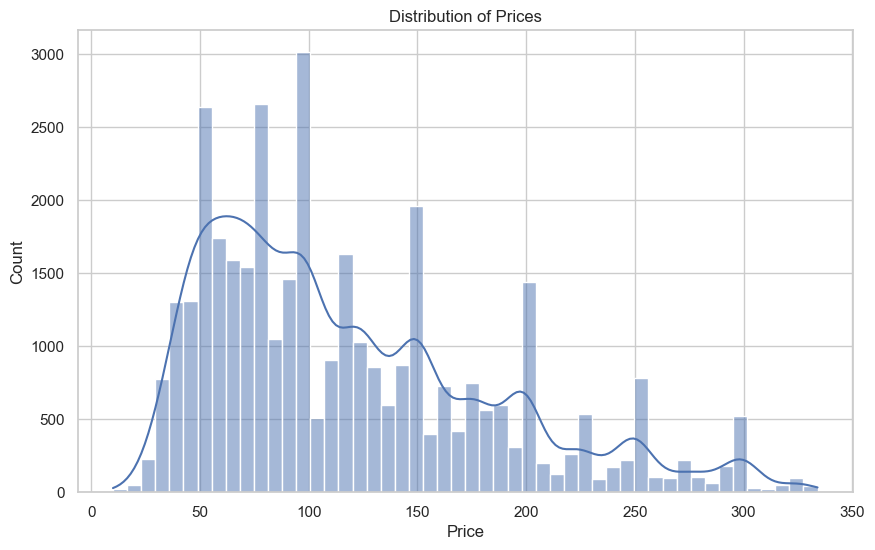

In [46]:
#  Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


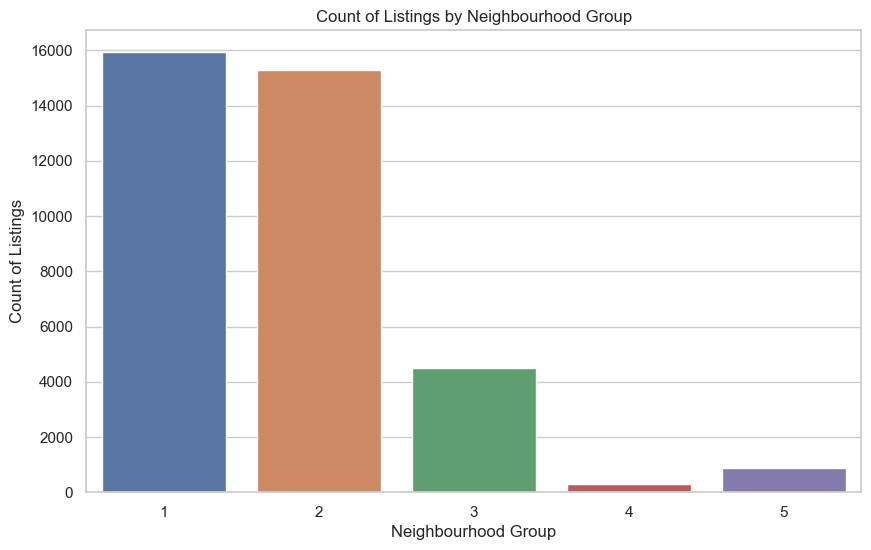

In [47]:
# Count of Listings by Neighbourhood Group
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='neighbourhood_group')
plt.title('Count of Listings by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count of Listings')
plt.show()

C:\Users\hemus\AppData\Local\Temp\ipykernel_28924\965455949.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='room_type', y='price', estimator=np.mean, ci=None)


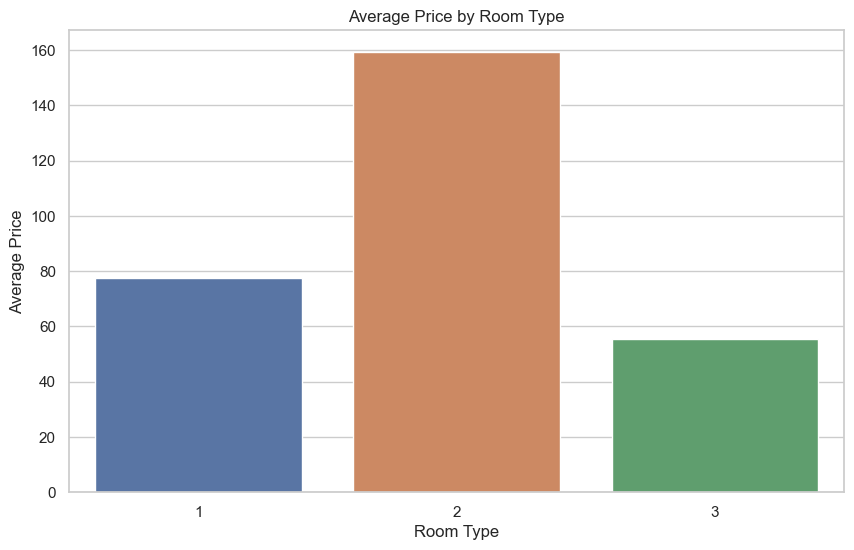

In [48]:
# Average Price by Room Type
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='room_type', y='price', estimator=np.mean, ci=None)
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.show()

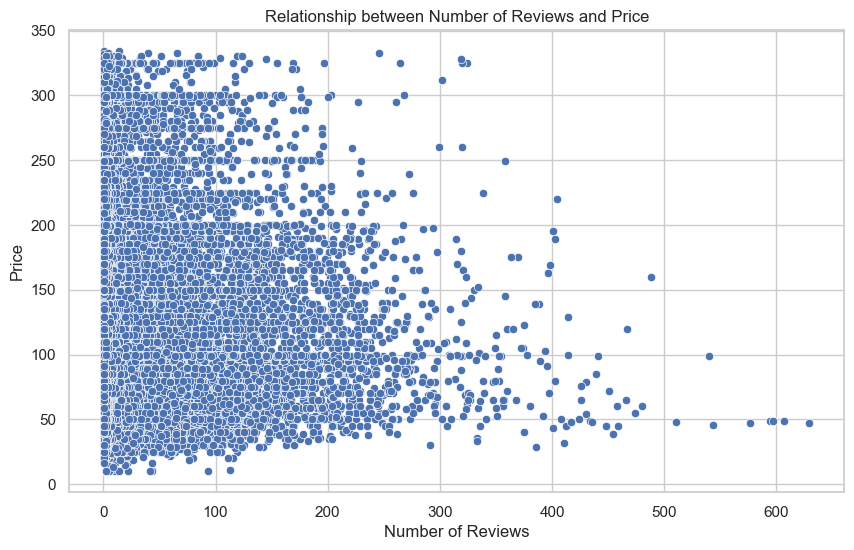

In [49]:
# Relationship between Reviews and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='number_of_reviews', y='price')
plt.title('Relationship between Number of Reviews and Price')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.show()

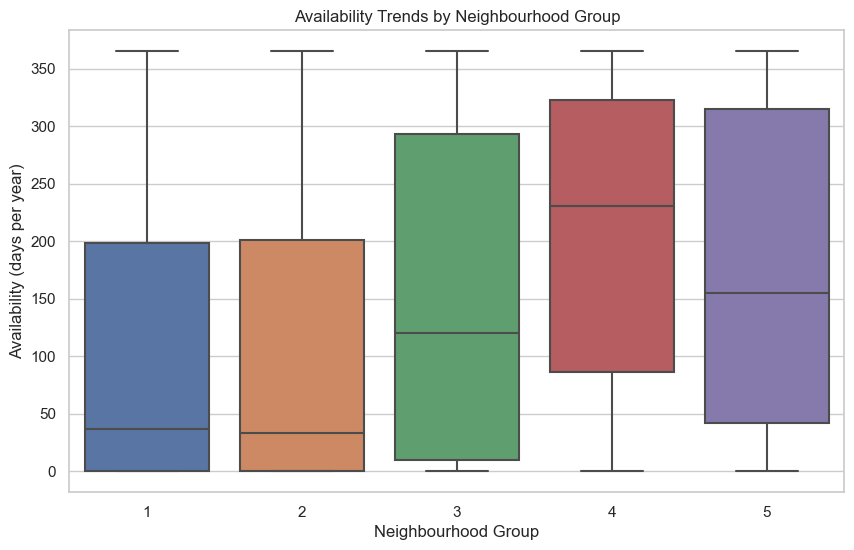

In [50]:
#  Availability Trends by Neighbourhood Group
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='neighbourhood_group', y='availability_365')
plt.title('Availability Trends by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Availability (days per year)')
plt.show()

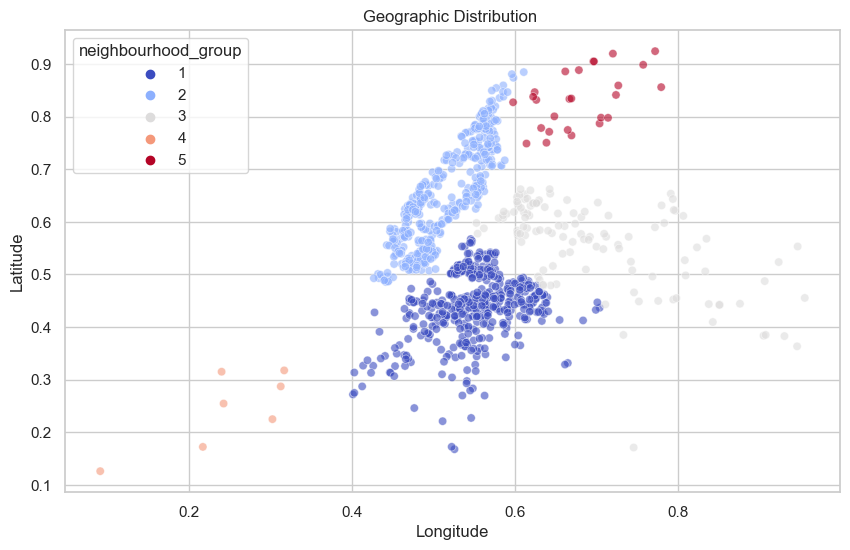

In [51]:
# Geographic Heatmap  (Using a sample for visualization purposes)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(1000), x='longitude', y='latitude', hue='neighbourhood_group', palette='coolwarm', alpha=0.6)
plt.title('Geographic Distribution ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

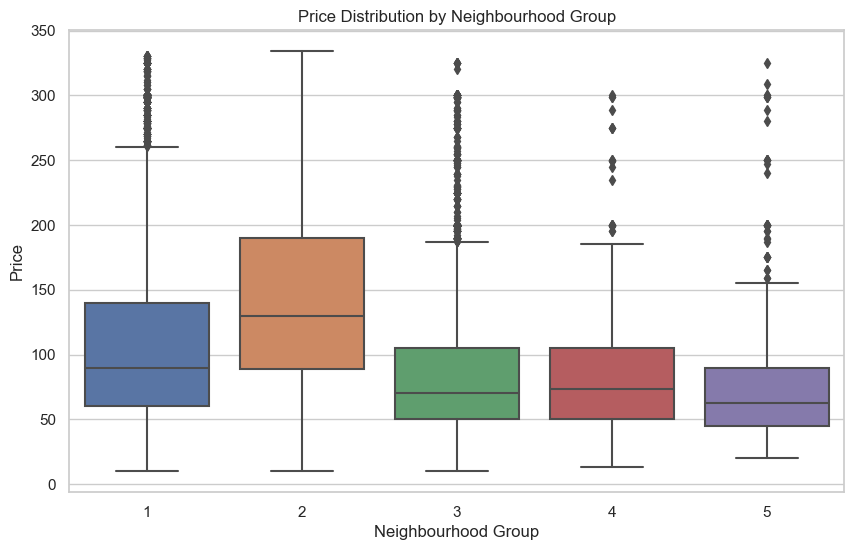

In [52]:
# 7. Price Distribution by Neighbourhood Group
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='neighbourhood_group', y='price')
plt.title('Price Distribution by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price')
plt.show()

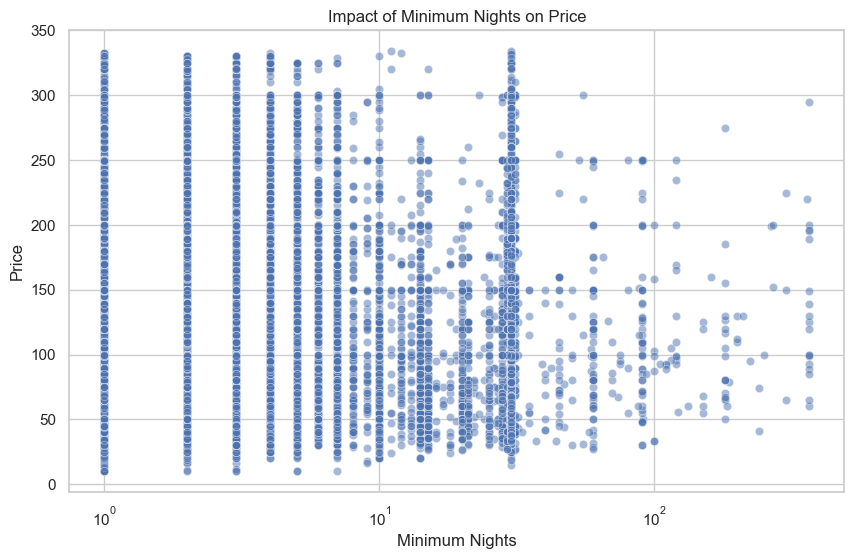

In [53]:
# Impact of Minimum Nights on Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='minimum_nights', y='price', alpha=0.5)
plt.title('Impact of Minimum Nights on Price')
plt.xlabel('Minimum Nights')
plt.xscale('log') # log scale has been used due to wider range of values.
plt.ylabel('Price')
plt.show()

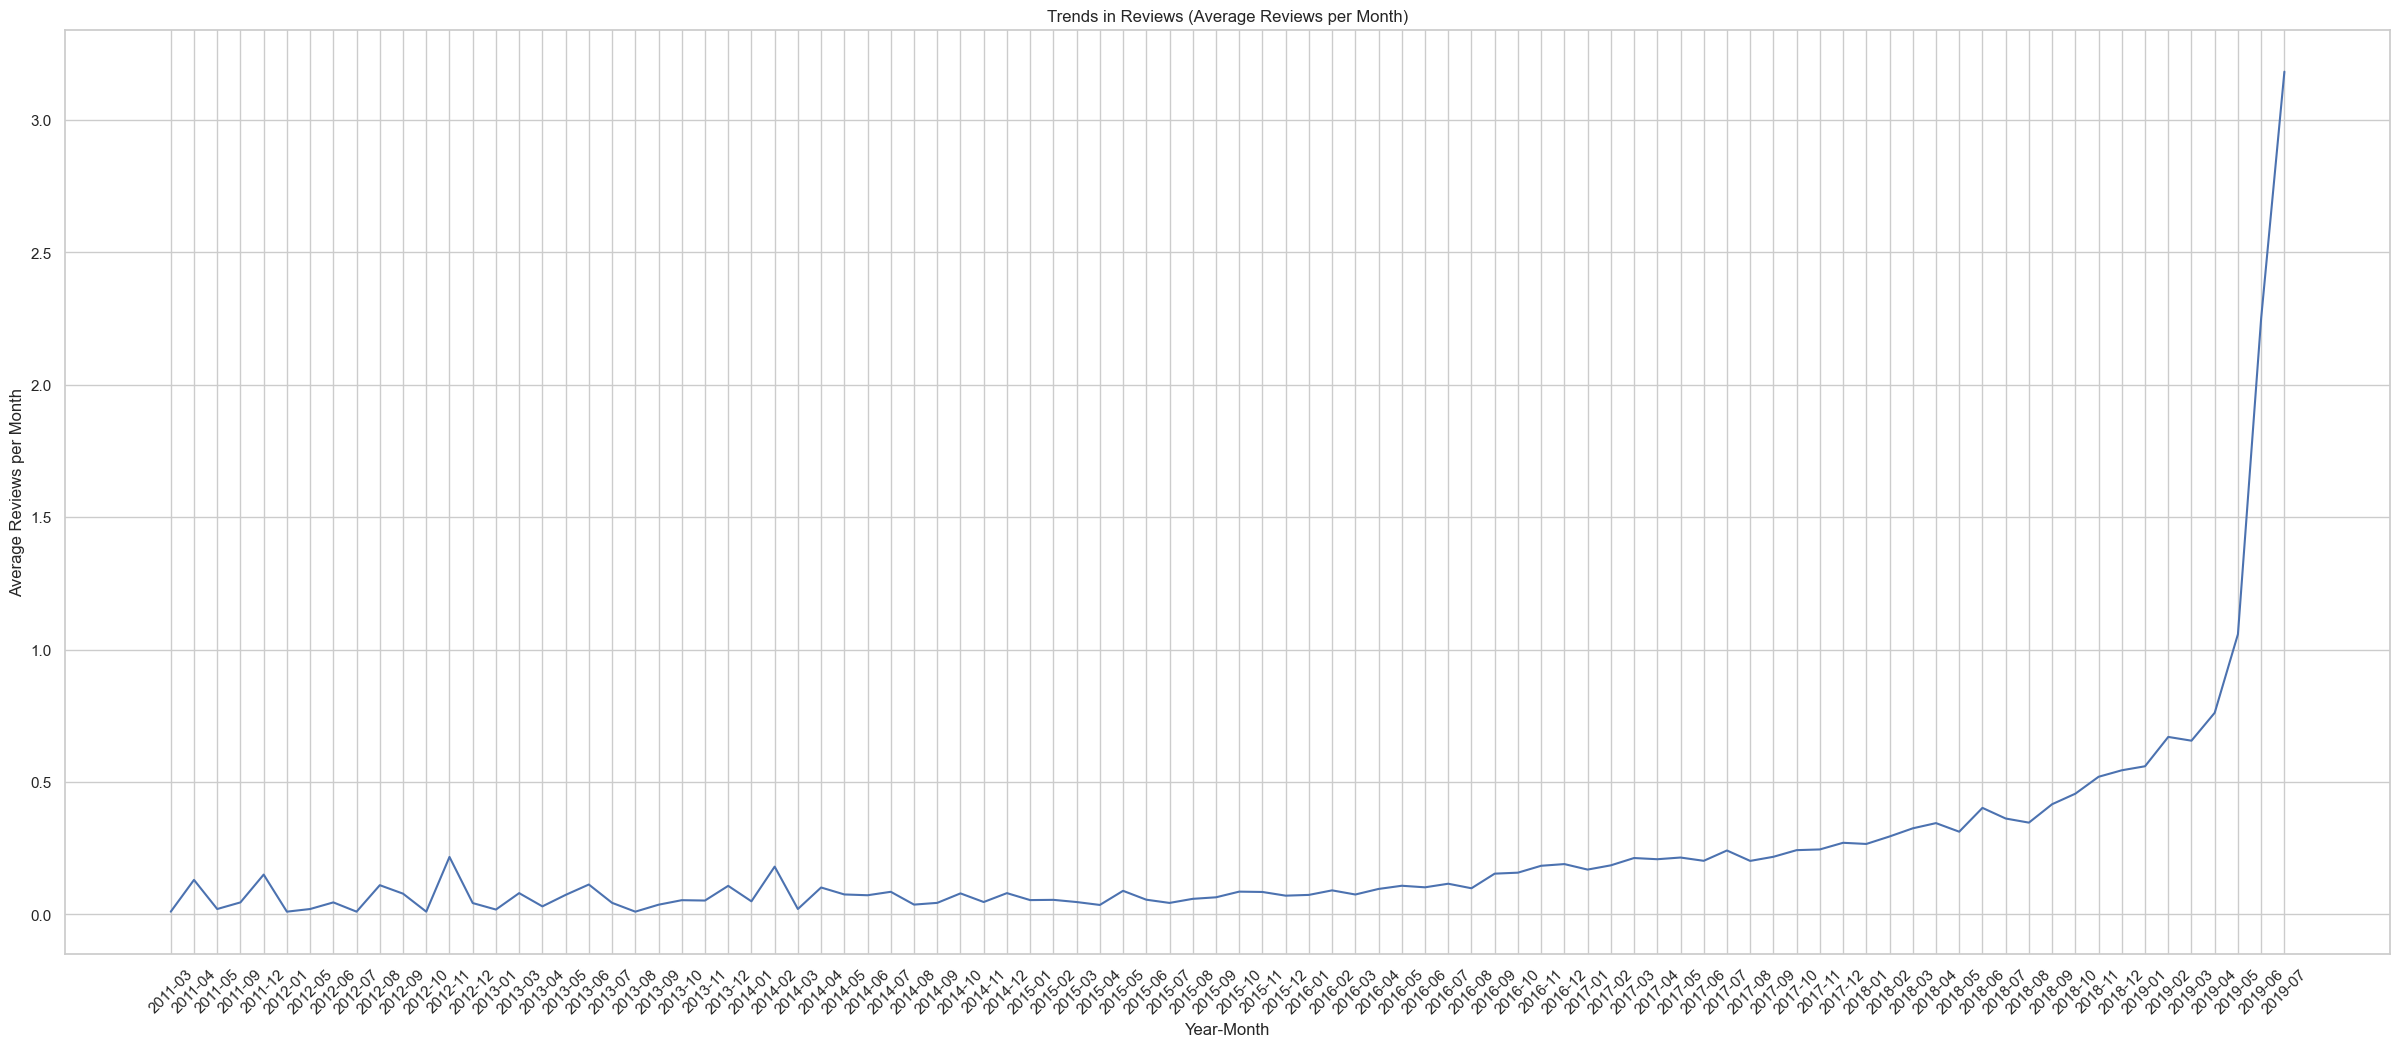

In [54]:
#   Trends in Reviews (Average Reviews per Month Over Time)
df['year_month'] = df['last_review'].dt.to_period('M')
reviews_time_series = df.groupby('year_month')['reviews_per_month'].mean().reset_index()
reviews_time_series['year_month'] = reviews_time_series['year_month'].astype(str)
plt.figure(figsize=(30, 12))
sns.lineplot(data=reviews_time_series, x='year_month', y='reviews_per_month')
plt.title('Trends in Reviews (Average Reviews per Month)')
plt.xlabel('Year-Month')
plt.ylabel('Average Reviews per Month')
plt.xticks(rotation=45)
plt.show()

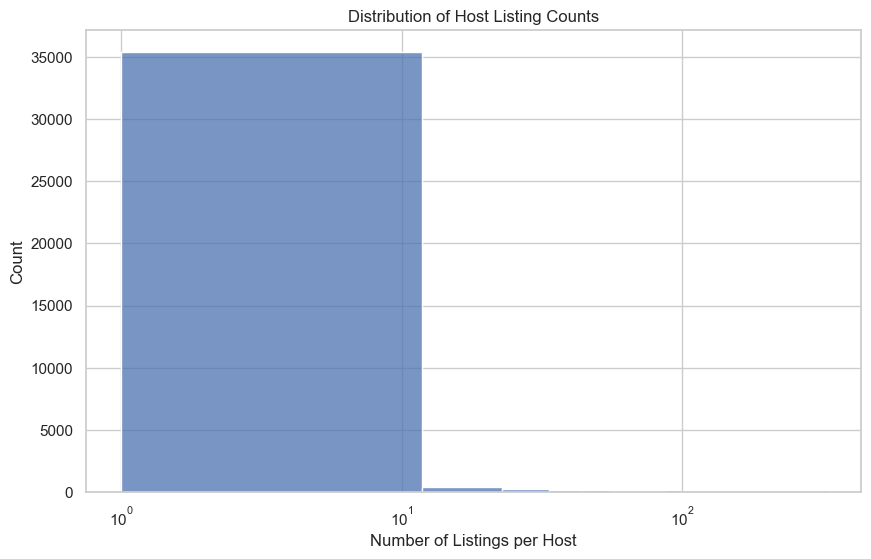

In [55]:
# Host Listing Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['calculated_host_listings_count'], bins=30, kde=False)
plt.title('Distribution of Host Listing Counts')
plt.xlabel('Number of Listings per Host')
plt.ylabel('Count')
plt.xscale('log') # Using logarithmic scale due to wide range of values
plt.show()

C:\Users\hemus\AppData\Local\Temp\ipykernel_28924\2337461540.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


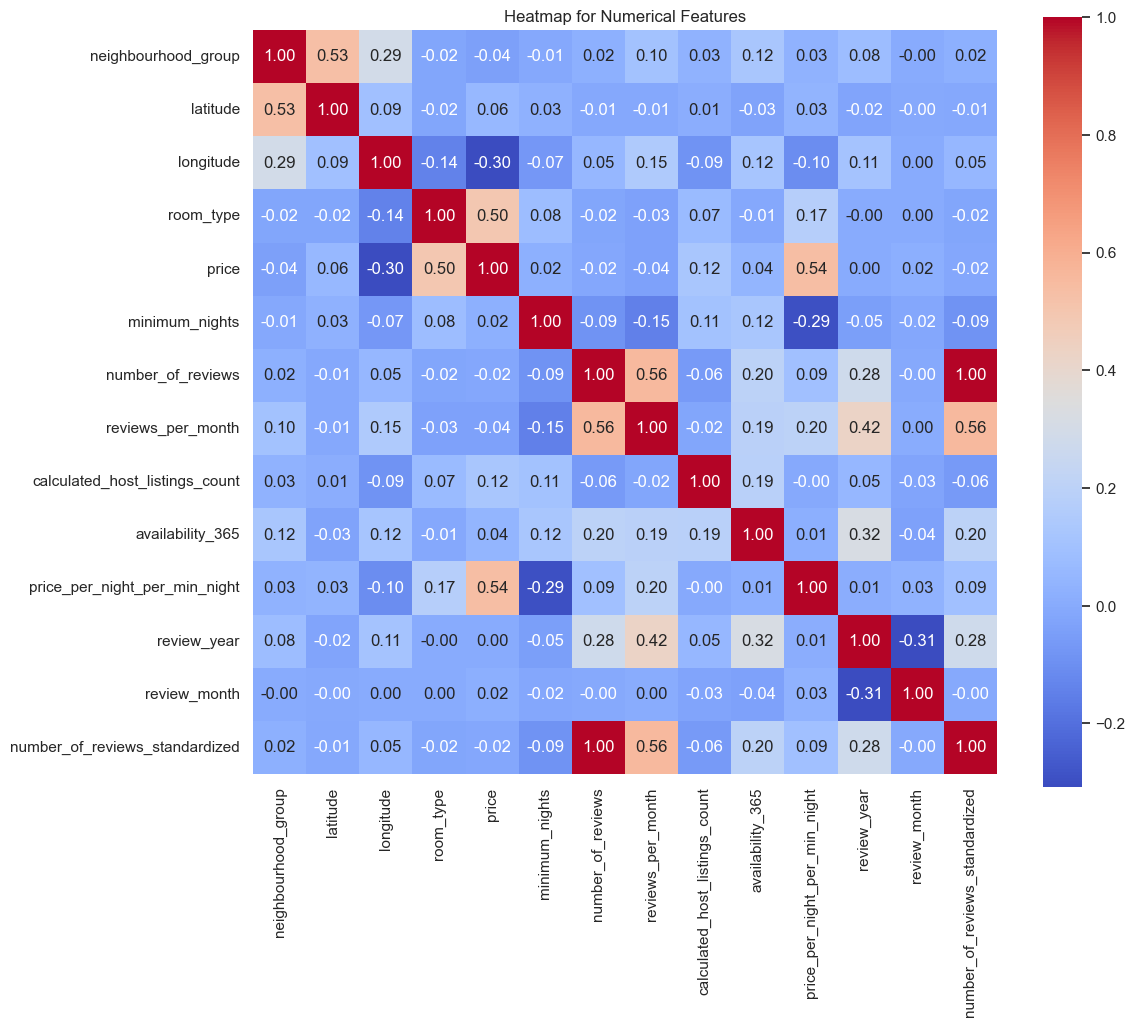

In [56]:
#Heat map of the numerical features of the dataset:
# Calculate the correlation matrix for the numerical features of the DataFrame
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Heatmap for Numerical Features')
plt.show()

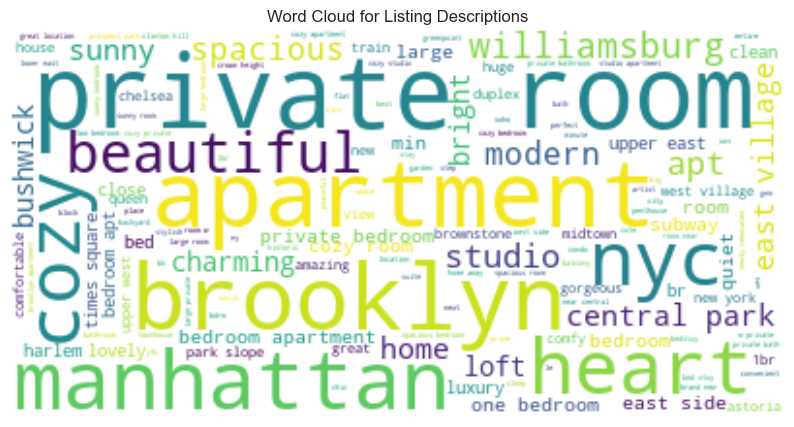

In [57]:
#Visualizing the most common words in the  descriptions.
text = ' '.join(i for i in df['name'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud for Listing Descriptions')
plt.show()

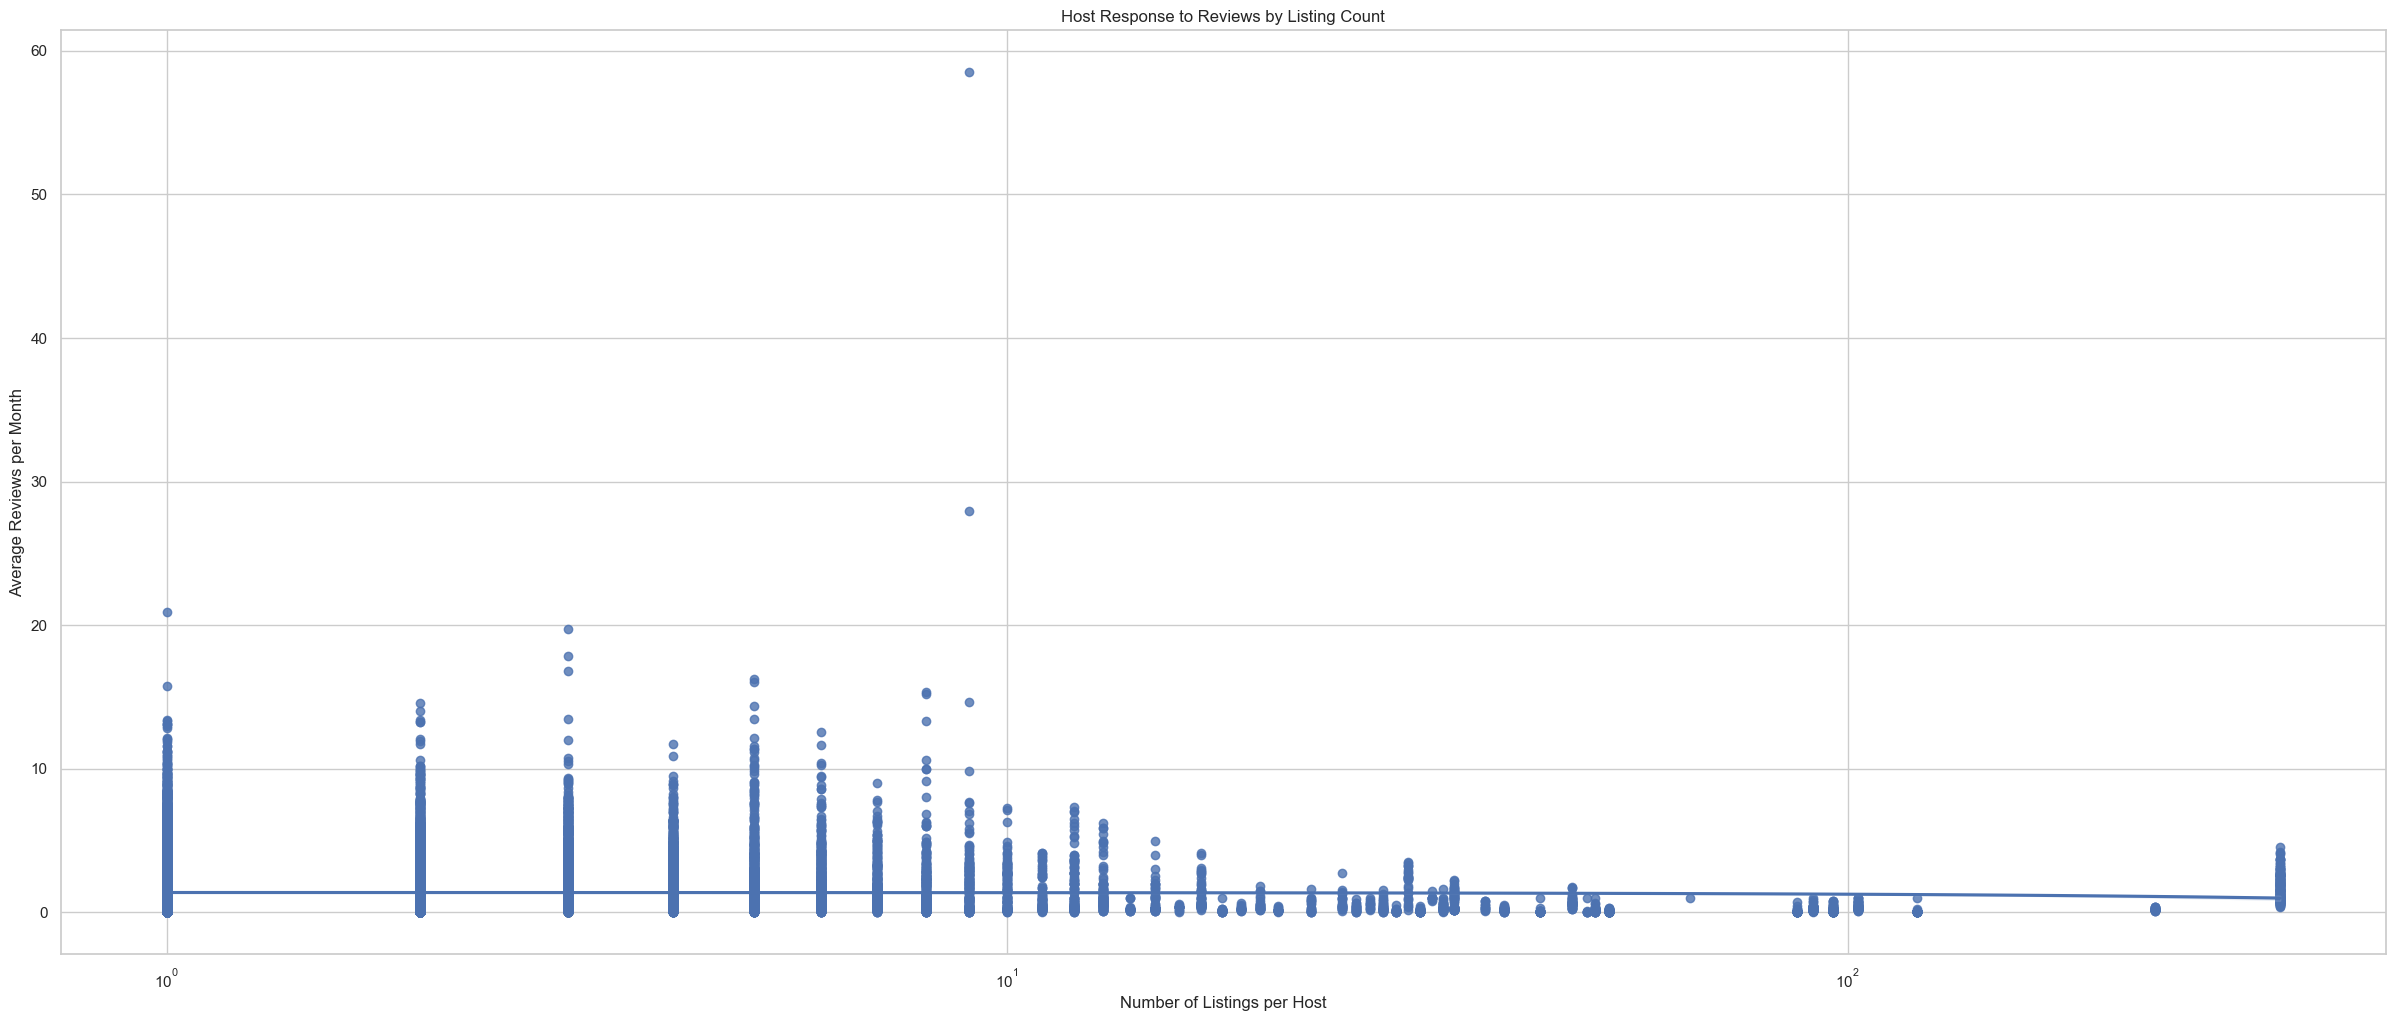

In [58]:
#Host Response to Reviews(Examine how the number of listings affects host responsiveness to reviews.)
#Scatterplot with a regression line.
plt.figure(figsize=(30, 12))
sns.regplot(data=df, x='calculated_host_listings_count', y='reviews_per_month')
plt.title('Host Response to Reviews by Listing Count')
plt.xlabel('Number of Listings per Host')
plt.ylabel('Average Reviews per Month')
plt.xscale('log')
plt.show()

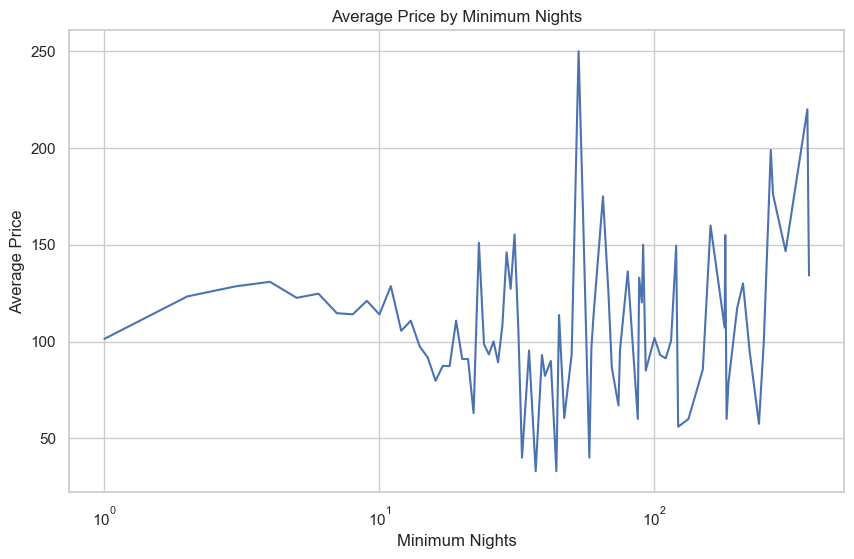

In [59]:
#Length of Stay vs. Price
avg_price_per_night = df.groupby('minimum_nights')['price'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price_per_night, x='minimum_nights', y='price')
plt.title('Average Price by Minimum Nights')
plt.xlabel('Minimum Nights')
plt.ylabel('Average Price')
plt.xscale('log')
plt.show()

# Phase 2

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

numerical_features = df[['latitude', 'longitude', 'neighbourhood_group', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

# Splitting the data into features (X) and target (y)
X = numerical_features.drop('price', axis=1)
y = numerical_features['price']

numerical_columns = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((29516, 9), (7379, 9), (29516,), (7379,))

In [61]:
df


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_per_night_per_min_night,review_year,review_month,number_of_reviews_standardized,name_cleaned,year_month
0,2539,clean & quiet apt home by the park,2787,John,1,Kensington,0.347,0.512,1,149,...,2018-10-19,0.21,6,365,149.000,2018,10,-0.426,clean & quiet apt home by the park,2018-10
1,2595,skylit midtown castle,2845,Jennifer,2,Midtown,0.608,0.490,2,225,...,2019-05-21,0.38,2,355,225.000,2019,5,0.312,skylit midtown castle,2019-05
2,3831,cozy entire floor of brownstone,4869,LisaRoxanne,1,Clinton Hill,0.440,0.536,2,89,...,2019-07-05,4.64,1,194,89.000,2019,7,4.923,cozy entire floor of brownstone,2019-07
3,5022,entire apt: spacious studio/loft by central park,7192,Laura,2,East Harlem,0.718,0.565,2,80,...,2018-11-19,0.10,1,0,8.000,2018,11,-0.426,entire apt: spacious studio/loft by central park,2018-11
4,5099,large cozy 1 br apartment in midtown east,7322,Chris,2,Murray Hill,0.593,0.507,2,200,...,2019-06-22,0.59,1,129,66.667,2019,6,0.906,large cozy 1 br apartment in midtown east,2019-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36890,36425863,lovely privet bedroom with privet restroom,83554966,Rusaa,2,Upper East Side,0.675,0.547,1,129,...,2019-07-07,1.00,1,147,129.000,2019,7,-0.590,lovely privet bedroom with privet restroom,2019-07
36891,36427429,no.2 with queen size bed,257683179,H Ai,3,Flushing,0.602,0.809,1,45,...,2019-07-07,1.00,6,339,45.000,2019,7,-0.590,no.2 with queen size bed,2019-07
36892,36438336,seas the moment,211644523,Ben,4,Great Kills,0.087,0.191,1,235,...,2019-07-07,1.00,1,87,235.000,2019,7,-0.590,seas the moment,2019-07
36893,36442252,1b-1b apartment near by metro,273841667,Blaine,5,Mott Haven,0.741,0.603,2,100,...,2019-07-07,2.00,1,40,100.000,2019,7,-0.569,1b-1b apartment near by metro,2019-07


In [65]:
average_price = df['price'].mean()
max_price = df['price'].max()
min_price = df['price'].min()
print(average_price)
print(max_price)
print(min_price)

118.1836021141076
334
10


In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

# Initialize
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_linear = linear_model.predict(X_test)
linear_rmse = mean_squared_error(y_test, y_pred_linear, squared=False)
linear_r2 = r2_score(y_test, y_pred_linear)

print(f"linear regression RMSE:{linear_rmse}")
print(f"linear regression R2:{linear_r2}")


linear regression RMSE:55.5675689819255
linear regression R2:0.31569962456377365


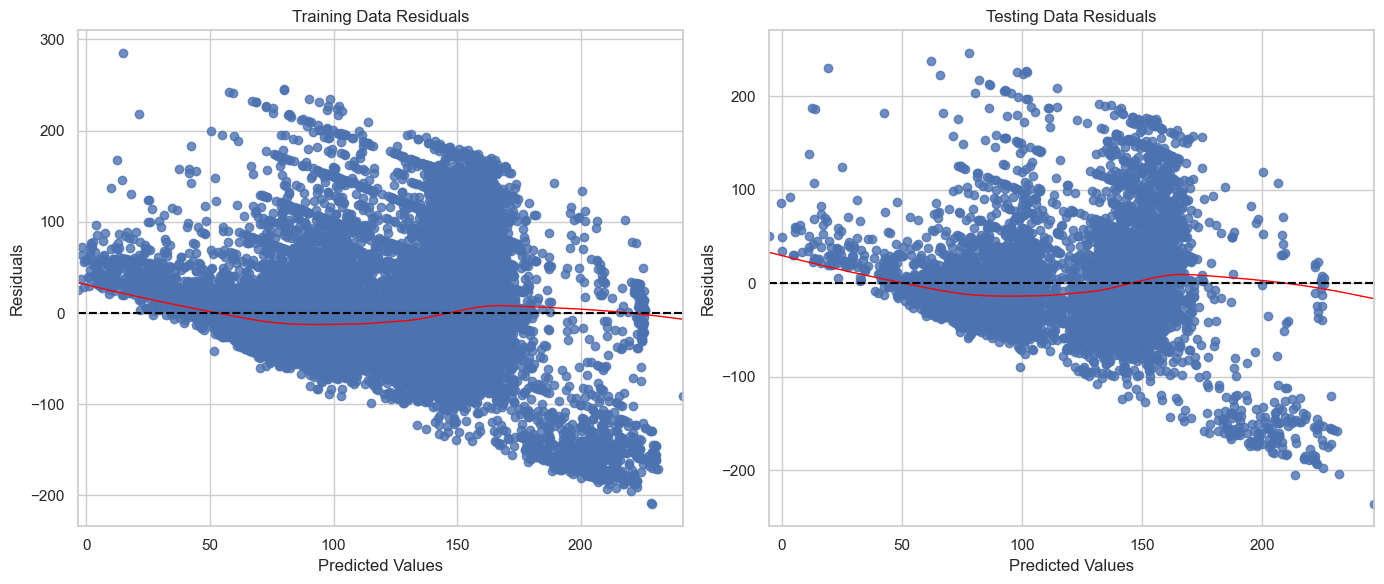

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on training data
y_train_pred = linear_model.predict(X_train)

train_residuals = y_train - y_train_pred
test_residuals = y_test - y_pred_linear

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Training data residual plot
sns.residplot(x=y_train_pred, y=train_residuals, lowess=True, ax=ax[0], line_kws={'color': 'red', 'lw': 1})
ax[0].set_title('Training Data Residuals')
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].axhline(y=0, color='black', linestyle='--')

# Testing data residual plot
sns.residplot(x=y_pred_linear, y=test_residuals, lowess=True, ax=ax[1], line_kws={'color': 'red', 'lw': 1})
ax[1].set_title('Testing Data Residuals')
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('Residuals')
ax[1].axhline(y=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()


In [71]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


# Initialize the k-NN 
knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': np.arange(1, 6),  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}


grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)


# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

# Use the best model to make predictions
y_pred_knn = grid_search.predict(X_test)

knn_rmse = mean_squared_error(y_test, y_pred_knn, squared=False)
knn_r2 = r2_score(y_test, y_pred_knn)

print(f"K-NN RMSE: {knn_rmse}")
print(f"K-NN R2: {knn_r2}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
K-NN RMSE: 46.86631241605377
K-NN R2: 0.5132280433996699


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_pred = grid_search.best_estimator_.predict(X_train)

# Calculate the residuals for both training and testing data
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_pred_knn

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Training data residual plot
sns.residplot(x=y_train_pred, y=train_residuals, lowess=True, ax=ax[0], line_kws={'color': 'red', 'lw': 1})
ax[0].set_title('Training Data Residuals')
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].axhline(y=0, color='black', linestyle='--')

# Testing data residual plot
sns.residplot(x=y_pred_knn, y=test_residuals, lowess=True, ax=ax[1], line_kws={'color': 'red', 'lw': 1})
ax[1].set_title('Testing Data Residuals')
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('Residuals')
ax[1].axhline(y=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score

#  the target for classification: Above (1) or Below (0) median price
median_price = df['price'].median()
y_class = (y > median_price).astype(int) 

# Splitting the dataset for classification task
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

nb_model = GaussianNB()

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=4)  # Exploring 4 values from 1 to 1e-9
}


grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train_class, y_train_class)

print("Best parameters found: ", grid_search.best_params_)

y_pred_nb = grid_search.predict(X_test_class)

# Evaluate the best model
nb_accuracy = accuracy_score(y_test_class, y_pred_nb)
nb_f1 = f1_score(y_test_class, y_pred_nb, average='binary')

print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(f"Naive Bayes F1: {nb_f1}")


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob_nb = grid_search.best_estimator_.predict_proba(X_test_class)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_class, y_prob_nb)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

logistic_model = LogisticRegression(max_iter=1000)

param_grid = [
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['newton-cg', 'liblinear', 'saga']},
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']}
]

grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train_class, y_train_class)

print("Best parameters found: ", grid_search.best_params_)

y_pred_logistic = grid_search.predict(X_test_class)

# Evaluate the best model found by the grid search
logistic_accuracy = accuracy_score(y_test_class, y_pred_logistic)
logistic_f1 = f1_score(y_test_class, y_pred_logistic, average='binary')

print(f"Logistic Regression Accuracy: {logistic_accuracy}")
print(f"F1-score: {logistic_f1}")

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob_lr = grid_search.best_estimator_.predict_proba(X_test_class)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_class, y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 10],  
    'criterion': ['gini', 'entropy'] 
}

grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train_class, y_train_class)

print("Best parameters found: ", grid_search.best_params_)

# Use the best model to make predictions
y_pred_dt = grid_search.predict(X_test_class)

# Evaluate the best model
dt_accuracy = accuracy_score(y_test_class, y_pred_dt)
dt_f1 = f1_score(y_test_class, y_pred_dt, average='binary')

print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"F1-score: {dt_f1}")



In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob_dt = grid_search.best_estimator_.predict_proba(X_test_class)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_class, y_prob_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [76]:
print(X_test)

       latitude  longitude  neighbourhood_group  room_type  minimum_nights  \
20468     0.656      0.651                    3          2          -0.198   
26494    -1.148     -0.132                    1          2          -0.270   
4984     -0.811      0.644                    1          2          -0.270   
8957     -0.333      1.106                    3          2          -0.054   
7579      0.989     -0.740                    2          2           1.751   
...         ...        ...                  ...        ...             ...   
18429    -0.440      0.498                    1          2          -0.343   
9279     -0.693     -0.208                    1          1          -0.054   
36555     2.076      0.219                    2          2          -0.054   
19501    -0.051     -0.683                    2          2          -0.198   
13396     0.560      0.437                    3          2          -0.270   

       number_of_reviews  reviews_per_month  calculated_host_li

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor(random_state=42)

# Define a reduced hyperparameter grid
param_grid = {
    'n_estimators': [100, 150],  
    'learning_rate': [0.1, 0.2],  
    
}

grid_search = GridSearchCV(gbr_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

y_pred_gbr = grid_search.best_estimator_.predict(X_test)

# Evaluate the best model
gbr_rmse = mean_squared_error(y_test, y_pred_gbr, squared=False)
gbr_r2 = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting RMSE: {gbr_rmse}")
print(f"R-squared: {gbr_r2}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'learning_rate': 0.2, 'n_estimators': 150}
Gradient Boosting RMSE: 43.67854189735724
R-squared: 0.5771948702824106


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_pred_gbr = grid_search.best_estimator_.predict(X_train)

train_residuals_gbr = y_train - y_train_pred_gbr
test_residuals_gbr = y_test - y_pred_gbr

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training data residuals
sns.residplot(x=y_train_pred_gbr, y=train_residuals_gbr, lowess=True, ax=axes[0], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1})
axes[0].set_title('Training Data Residuals')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].axhline(y=0, color='black', linestyle='--')

# Testing data residuals
sns.residplot(x=y_pred_gbr, y=test_residuals_gbr, lowess=True, ax=axes[1], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1})
axes[1].set_title('Testing Data Residuals')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].axhline(y=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Model': ['Linear Regression', 'K-NN', 'Gradient Boosting'],
    'RMSE': [linear_rmse, knn_rmse, gbr_rmse],  
}

df = pd.DataFrame(data)

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=df, palette='coolwarm')
plt.title('RMSE for Regression Models')
plt.xlabel('Model')
plt.ylabel('RMSE Score')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example data: model names and their R2 scores
data = {
    'Model': ['Linear Regression', 'K-NN', 'Gradient Boosting'],
    'R2': [linear_r2, knn_r2, gbr_r2],  
}

df = pd.DataFrame(data)

# Plotting R2 scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=df, palette='coolwarm')
plt.title('R2 for Regression Models')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.show()

# Phase 3

In [70]:
import pickle
model_filename = 'gradient_boosting_regressor.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)

In [68]:
model_filename

'gradient_boosting_regressor.pkl'

In [74]:
pip show scikit-learn

Name: scikit-learn
Version: 1.3.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\Users\hemus\anaconda3\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: daal4py, imbalanced-learn, scikit-learn-intelex
Note: you may need to restart the kernel to use updated packages.


In [75]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_per_night_per_min_night,review_year,review_month,number_of_reviews_standardized,name_cleaned,year_month
0,2539,clean & quiet apt home by the park,2787,John,1,Kensington,0.347,0.512,1,149,...,2018-10-19,0.21,6,365,149.000,2018,10,-0.426,clean & quiet apt home by the park,2018-10
1,2595,skylit midtown castle,2845,Jennifer,2,Midtown,0.608,0.490,2,225,...,2019-05-21,0.38,2,355,225.000,2019,5,0.312,skylit midtown castle,2019-05
2,3831,cozy entire floor of brownstone,4869,LisaRoxanne,1,Clinton Hill,0.440,0.536,2,89,...,2019-07-05,4.64,1,194,89.000,2019,7,4.923,cozy entire floor of brownstone,2019-07
3,5022,entire apt: spacious studio/loft by central park,7192,Laura,2,East Harlem,0.718,0.565,2,80,...,2018-11-19,0.10,1,0,8.000,2018,11,-0.426,entire apt: spacious studio/loft by central park,2018-11
4,5099,large cozy 1 br apartment in midtown east,7322,Chris,2,Murray Hill,0.593,0.507,2,200,...,2019-06-22,0.59,1,129,66.667,2019,6,0.906,large cozy 1 br apartment in midtown east,2019-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36890,36425863,lovely privet bedroom with privet restroom,83554966,Rusaa,2,Upper East Side,0.675,0.547,1,129,...,2019-07-07,1.00,1,147,129.000,2019,7,-0.590,lovely privet bedroom with privet restroom,2019-07
36891,36427429,no.2 with queen size bed,257683179,H Ai,3,Flushing,0.602,0.809,1,45,...,2019-07-07,1.00,6,339,45.000,2019,7,-0.590,no.2 with queen size bed,2019-07
36892,36438336,seas the moment,211644523,Ben,4,Great Kills,0.087,0.191,1,235,...,2019-07-07,1.00,1,87,235.000,2019,7,-0.590,seas the moment,2019-07
36893,36442252,1b-1b apartment near by metro,273841667,Blaine,5,Mott Haven,0.741,0.603,2,100,...,2019-07-07,2.00,1,40,100.000,2019,7,-0.569,1b-1b apartment near by metro,2019-07


In [77]:
from sklearn.preprocessing import StandardScaler 
import pickle


scaler = StandardScaler()
scaler.fit(X_train)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)


In [66]:
import matplotlib
print(matplotlib.__version__)


3.7.1
